<a href="https://colab.research.google.com/github/hagalaz-star/PROJECT/blob/main/PROJECT5_AI_06_%EC%B5%9C%EC%9B%90%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
yolo v3 구현 사물인식

In [ ]:
pip install --upgrade pandas

     |████████████████████████████████| 11.3 MB 10.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels ,kernel_size = 3, stride =1  , padding = 1):## if groups = in_channels then this is depth_wise convolution operation
        super(CNNBlock , self).__init__()
        self.conv2d = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size , stride = stride , padding = padding , bias = False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
    def forward(self,x):
        return self.leaky_relu(self.batchnorm(self.conv2d(x)))
    

In [ ]:
class YoloV1(nn.Module):
    def __init__(self,grid_size,n_box , n_class , input_channels = 3):# S = grid_size , n_box = Bounding boxes , n_class = how many classes for classification!
        super(YoloV1 , self).__init__()
        ## This will be a long one so you can pass it if you want. Basicly creating the same model on the pic. above.
        
        self.darknet = nn.Sequential(
                     CNNBlock(in_channels = input_channels , out_channels = 64,kernel_size = 7 , stride = 2 , padding = 3),
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 64 , out_channels = 192,kernel_size = 3 , stride = 2 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 192 , out_channels = 128,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 128 , out_channels = 256,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 256 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),   
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0),
                     
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),      
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),    
                     CNNBlock(in_channels = 512 , out_channels = 256,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 256 , out_channels = 512,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 512 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     nn.MaxPool2d(kernel_size = 2 , stride=2),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),
                     CNNBlock(in_channels = 1024 , out_channels = 512,kernel_size = 1 , stride = 1 , padding = 0), 
                     CNNBlock(in_channels = 512 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1), 

                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 2 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 2), 
                     CNNBlock(in_channels = 1024 , out_channels = 1024,kernel_size = 3 , stride = 1 , padding = 1),   
                        )
       
        self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear((1024*grid_size*grid_size) , 4096), #output of darknet will be S x S x 1024
                nn.Dropout(0.4),
                nn.LeakyReLU(0.1),
                nn.Linear(4096 , grid_size*grid_size*(n_class + n_box*5)) # there will be n_class + n_box*5 outputs for each grid (we multiplt n_box with  5 because each box contains; midpoint_x , midpoint_y , width , height ,confidence  )
                )
        
    def forward(self,x):
        x = self.darknet(x)
        return self.fc(x)
         

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [ ]:
def IOU(boxes_preds, boxes_labels, box_format="midpoint"):
  
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

yolo3 구현 실패
이유 : YOLO V1 darknet 프레임 워크 이해부족 

하지만 그래도 소스코드 를 통해 진행을 강제함

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2

In [ ]:
_BATCH_NORM_DECAY = 0.9
_BATCH_NORM_EPSILON = 1e-05
_LEAKY_RELU = 0.1
_ANCHORS = [(10, 13), (16, 30), (33, 23),
            (30, 61), (62, 45), (59, 119),
            (116, 90), (156, 198), (373, 326)]
_MODEL_SIZE = (416, 416)

In [ ]:
def batch_norm(inputs, training, data_format):
    
    return tf.layers.batch_normalization(
        inputs=inputs, axis=1 if data_format == 'channels_first' else 3,
        momentum=_BATCH_NORM_DECAY, epsilon=_BATCH_NORM_EPSILON,
        scale=True, training=training)

In [ ]:

def fixed_padding(inputs, kernel_size, data_format):
 me format as the input.
 

In [ ]:
def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
    """Creates a residual block for Darknet."""
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs


def darknet53_residual_block(inputs, filters, training, data_format,
                             strides=1):
    """Creates a residual block for Darknet."""
    shortcut = inputs

    inputs = conv2d_fixed_padding(
        inputs, filters=filters, kernel_size=1, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(
        inputs, filters=2 * filters, kernel_size=3, strides=strides,
        data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs += shortcut

    return inputs


def darknet53(inputs, training, data_format):
    """Creates Darknet53 model for feature extraction."""
    inputs = conv2d_fixed_padding(inputs, filters=32, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
    inputs = conv2d_fixed_padding(inputs, filters=64, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = darknet53_residual_block(inputs, filters=32, training=training,
                                      data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=128, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(2):
        inputs = darknet53_residual_block(inputs, filters=64,
                                          training=training,
                                          data_format=data_format)

    inputs = conv2d_fixed_padding(inputs, filters=256, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)


    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=128,
                                          training=training,
                                          data_format=data_format)

    route1 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=512, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(8):
        inputs = darknet53_residual_block(inputs, filters=256,
                                          training=training,
                                          data_format=data_format)

    route2 = inputs

    inputs = conv2d_fixed_padding(inputs, filters=1024, kernel_size=3,
                                  strides=2, data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    for _ in range(4):
        inputs = darknet53_residual_block(inputs, filters=512,
                                          training=training,
                                          data_format=data_format)

    return route1, route2, inputs


In [ ]:
def yolo_convolution_block(inputs, filters, training, data_format):
    """Creates convolution operations layer used after Darknet."""
    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    inputs = conv2d_fixed_padding(inputs, filters=filters, kernel_size=1,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    route = inputs

    inputs = conv2d_fixed_padding(inputs, filters=2 * filters, kernel_size=3,
                                  data_format=data_format)
    inputs = batch_norm(inputs, training=training, data_format=data_format)
    inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)

    return route, inputs

In [ ]:
def yolo_layer(inputs, n_classes, anchors, img_size, data_format):

    n_anchors = len(anchors)

    inputs = tf.layers.conv2d(inputs, filters=n_anchors * (5 + n_classes),
                              kernel_size=1, strides=1, use_bias=True,
                              data_format=data_format)

    shape = inputs.get_shape().as_list()
    grid_shape = shape[2:4] if data_format == 'channels_first' else shape[1:3]
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
    inputs = tf.reshape(inputs, [-1, n_anchors * grid_shape[0] * grid_shape[1],
                                 5 + n_classes])

    strides = (img_size[0] // grid_shape[0], img_size[1] // grid_shape[1])

    box_centers, box_shapes, confidence, classes = \
        tf.split(inputs, [2, 2, 1, n_classes], axis=-1)

    x = tf.range(grid_shape[0], dtype=tf.float32)
    y = tf.range(grid_shape[1], dtype=tf.float32)
    x_offset, y_offset = tf.meshgrid(x, y)
    x_offset = tf.reshape(x_offset, (-1, 1))
    y_offset = tf.reshape(y_offset, (-1, 1))
    x_y_offset = tf.concat([x_offset, y_offset], axis=-1)
    x_y_offset = tf.tile(x_y_offset, [1, n_anchors])
    x_y_offset = tf.reshape(x_y_offset, [1, -1, 2])
    box_centers = tf.nn.sigmoid(box_centers)
    box_centers = (box_centers + x_y_offset) * strides

    anchors = tf.tile(anchors, [grid_shape[0] * grid_shape[1], 1])
    box_shapes = tf.exp(box_shapes) * tf.to_float(anchors)

    confidence = tf.nn.sigmoid(confidence)

    classes = tf.nn.sigmoid(classes)

    inputs = tf.concat([box_centers, box_shapes,
                        confidence, classes], axis=-1)

    return inputs

In [ ]:
def upsample(inputs, out_shape, data_format):
    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 2, 3, 1])
        new_height = out_shape[3]
        new_width = out_shape[2]
    else:
        new_height = out_shape[2]
        new_width = out_shape[1]

    inputs = tf.image.resize_nearest_neighbor(inputs, (new_height, new_width))

    if data_format == 'channels_first':
        inputs = tf.transpose(inputs, [0, 3, 1, 2])

    return inputs

In [ ]:
def build_boxes(inputs):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)

    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2

    boxes = tf.concat([top_left_x, top_left_y,
                       bottom_right_x, bottom_right_y,
                       confidence, classes], axis=-1)

    return boxes


def non_max_suppression(inputs, n_classes, max_output_size, iou_threshold,
                        confidence_threshold):

    batch = tf.unstack(inputs)
    boxes_dicts = []
    for boxes in batch:
        boxes = tf.boolean_mask(boxes, boxes[:, 4] > confidence_threshold)
        classes = tf.argmax(boxes[:, 5:], axis=-1)
        classes = tf.expand_dims(tf.to_float(classes), axis=-1)
        boxes = tf.concat([boxes[:, :5], classes], axis=-1)

        boxes_dict = dict()
        for cls in range(n_classes):
            mask = tf.equal(boxes[:, 5], cls)
            mask_shape = mask.get_shape()
            if mask_shape.ndims != 0:
                class_boxes = tf.boolean_mask(boxes, mask)
                boxes_coords, boxes_conf_scores, _ = tf.split(class_boxes,
                                                              [4, 1, -1],
                                                              axis=-1)
                boxes_conf_scores = tf.reshape(boxes_conf_scores, [-1])
                indices = tf.image.non_max_suppression(boxes_coords,
                                                       boxes_conf_scores,
                                                       max_output_size,
                                                       iou_threshold)
                class_boxes = tf.gather(class_boxes, indices)
                boxes_dict[cls] = class_boxes[:, :5]

        boxes_dicts.append(boxes_dict)

    return boxes_dicts

In [ ]:
class Yolo_v3:
  

    def __init__(self, n_classes, model_size, max_output_size, iou_threshold,
                 confidence_threshold, data_format=None):
    

    def __call__(self, inputs, training):
       
        with tf.variable_scope('yolo_v3_model'):
            if self.data_format == 'channels_first':
                inputs = tf.transpose(inputs, [0, 3, 1, 2])

            inputs = inputs / 255

            route1, route2, inputs = darknet53(inputs, training=training,
                                               data_format=self.data_format)

            route, inputs = yolo_convolution_block(
                inputs, filters=512, training=training,
                data_format=self.data_format)
            detect1 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[6:9],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=256, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route2.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            axis = 1 if self.data_format == 'channels_first' else 3
            inputs = tf.concat([inputs, route2], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=256, training=training,
                data_format=self.data_format)
            detect2 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[3:6],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = conv2d_fixed_padding(route, filters=128, kernel_size=1,
                                          data_format=self.data_format)
            inputs = batch_norm(inputs, training=training,
                                data_format=self.data_format)
            inputs = tf.nn.leaky_relu(inputs, alpha=_LEAKY_RELU)
            upsample_size = route1.get_shape().as_list()
            inputs = upsample(inputs, out_shape=upsample_size,
                              data_format=self.data_format)
            inputs = tf.concat([inputs, route1], axis=axis)
            route, inputs = yolo_convolution_block(
                inputs, filters=128, training=training,
                data_format=self.data_format)
            detect3 = yolo_layer(inputs, n_classes=self.n_classes,
                                 anchors=_ANCHORS[0:3],
                                 img_size=self.model_size,
                                 data_format=self.data_format)

            inputs = tf.concat([detect1, detect2, detect3], axis=1)

            inputs = build_boxes(inputs)

            boxes_dicts = non_max_suppression(
                inputs, n_classes=self.n_classes,
                max_output_size=self.max_output_size,
                iou_threshold=self.iou_threshold,
                confidence_threshold=self.confidence_threshold)

            return boxes_dicts

In [ ]:
def load_images(img_names, model_size):
  
    imgs = []

    for img_name in img_names:
        img = Image.open(img_name)
        img = img.resize(size=model_size)
        img = np.array(img, dtype=np.float32)
        img = np.expand_dims(img, axis=0)
        imgs.append(img)

    imgs = np.concatenate(imgs)

    return imgs


def load_class_names(file_name):
    """Returns a list of class names read from `file_name`."""
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names


def draw_boxes(img_names, boxes_dicts, class_names, model_size):
  
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    for num, img_name, boxes_dict in zip(range(len(img_names)), img_names,
                                         boxes_dicts):
        img = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font='../input/futur.ttf',
                                  size=(img.size[0] + img.size[1]) // 100)
        resize_factor = \
            (img.size[0] / model_size[0], img.size[1] / model_size[1])
        for cls in range(len(class_names)):
            boxes = boxes_dict[cls]
            if np.size(boxes) != 0:
                color = colors[cls]
                for box in boxes:
                    xy, confidence = box[:4], box[4]
                    xy = [xy[i] * resize_factor[i % 2] for i in range(4)]
                    x0, y0 = xy[0], xy[1]
                    thickness = (img.size[0] + img.size[1]) // 200
                    for t in np.linspace(0, 1, thickness):
                        xy[0], xy[1] = xy[0] + t, xy[1] + t
                        xy[2], xy[3] = xy[2] - t, xy[3] - t
                        draw.rectangle(xy, outline=tuple(color))
                    text = '{} {:.1f}%'.format(class_names[cls],
                                               confidence * 100)
                    text_size = draw.textsize(text, font=font)
                    draw.rectangle(
                        [x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
                    draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)

        display(img)

In [ ]:
def load_weights(variables, file_name):
  
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.assign(conv_var, var_weights))

    return assign_ops

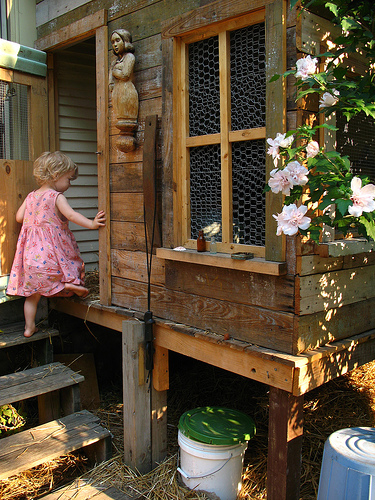

In [ ]:
img_names = ['/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg']
for img in img_names: display(Image.open(img))

In [ ]:
batch_size = len(img_names)
batch = load_images(img_names, model_size=_MODEL_SIZE)
class_names = load_class_names('/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg/coco.names')
n_classes = len(class_names)
max_output_size = 10
iou_threshold = 0.5
confidence_threshold = 0.5

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=max_output_size,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold)

inputs = tf.placeholder(tf.float32, [batch_size, 416, 416, 3])

detections = model(inputs, training=False)

model_vars = tf.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars,'/content/drive/MyDrive/Images/1000268201_693b08cb0e.jpg' )

with tf.Session() as sess:
    sess.run(assign_ops)
    detection_result = sess.run(detections, feed_dict={inputs: batch})
    

NotADirectoryError: ignored

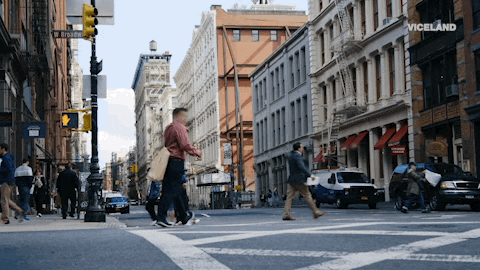

In [ ]:
from IPython.display import Image
with open('/street.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

+ 결국 제대로 된 결과물이 나오지 못하였다.


다른 방법으로 yolo 프로젝트 진행


In [ ]:
import torch
import torch.nn as nn

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x

In [ ]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )


In [ ]:

class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


In [ ]:
  def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels


            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers

        

yolo 방법에 대한 블로그 을 통해 코드를 적용 하지만 이 이후 결과 를 어떻게 진행할 방법을 몰라 실패
